# Data Prep

In [1]:
import pandas as pd
rway_img_df = pd.read_csv("collection_images_download.csv")
# EXTRACT BRAND FROM IMAGE NAME
rway_img_df['brand'] = rway_img_df['image_name'].str.lower()
rway_img_df['brand'] = rway_img_df['brand'].str.split('couture').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('ready-to-wear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('menswear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.replace("-", " ")
rway_img_df['brand'] = rway_img_df['brand'].str.strip()

# subset rway_img_df where brand cointains versage,hermes
#brand_keywords = ['rick owens', 'louis vuitton', 'versace', 'giorgio armani', 'hermes', 'dries van noten', 'chanel']
brand_keywords = ['rick owens', 'dries van noten','versace', 'louis vuitton','chanel','giorgio armani']

data = rway_img_df[rway_img_df['brand'].isin(brand_keywords)]

# rename brand in target column
data['target'] = data['brand']
# factorized 'brand' using pandas
data['target'] = pd.factorize(data['target'])[0]


/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_29637/3551661527.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['brand']
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_29637/3551661527.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = pd.factorize(data['target'])[0]


In [2]:
# Calculate the value counts of each brand in the 'brand' column
brand_counts = rway_img_df['brand'].value_counts()

# Print the brand names with count greater than 800
for brand, count in brand_counts.items():
    if count > 800:
        print(brand, count)

#! here the list of brand to predict without any class imbalance
#* ['rick owens', 'yohji yamamoto', 'louis vuitton', 'versace', 'giorgio armani', 'hermes', 'dries van noten', 'chanel']


valentino 1140
fendi 940
rick owens 880
yohji yamamoto 880
louis vuitton 880
versace 854
giorgio armani 841
hermes 840
dries van noten 840
chanel 840


# VGG16 with self attention - img with bkg

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

# My custom simple_vgg16 
def simple_vgg16_attention(input_shape=(224, 224, 3), num_classes=10):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    att_x = Attention()([x, x])  # Add Self-Attention layer here
    x = MaxPooling2D((2, 2))(att_x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Dense(256, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

   
# Load the image data and labels

# Split the data into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    data['image_path'],
    data['target'],
    test_size=0.2,
    random_state=1234
)

# Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(data['target']))}

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize
    return image

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train_paths])
X_val = np.array([preprocess_image(path) for path in X_val_paths])

# Convert the integer labels in y_train and y_val to one-hot encoded vectors using tf.keras.utils.to_categorical.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Create the custom simple_vgg16 model
input_shape = (img_height, img_width, 3)
model = simple_vgg16_attention(input_shape=input_shape, num_classes=num_classes)

# Compile the model with an appropriate optimizer and loss function (e.g., 'adam' optimizer and 'categorical_crossentropy' loss)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the preprocessed data
vgg16_selfattention = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))


2023-08-24 22:38:23.544639: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-24 22:38:23.545038: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-24 22:38:23.545582: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-24 22:38:23.545870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-24 22:38:23.546082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-08-24 22:38:32.181678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 1.7819 - accuracy: 0.1855

2023-08-24 22:38:54.311623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 25s 181ms/step - loss: 1.7819 - accuracy: 0.1855 - val_loss: 1.7072 - val_accuracy: 0.2590
Epoch 2/100
129/129 [==============================] - 21s 165ms/step - loss: 1.6575 - accuracy: 0.2661 - val_loss: 1.6258 - val_accuracy: 0.2804
Epoch 3/100
129/129 [==============================] - 21s 161ms/step - loss: 1.6174 - accuracy: 0.2724 - val_loss: 1.6683 - val_accuracy: 0.2658
Epoch 4/100
129/129 [==============================] - 21s 162ms/step - loss: 1.6045 - accuracy: 0.2967 - val_loss: 1.5711 - val_accuracy: 0.2999
Epoch 5/100
129/129 [==============================] - 21s 166ms/step - loss: 1.5578 - accuracy: 0.3267 - val_loss: 1.4977 - val_accuracy: 0.3661
Epoch 6/100
129/129 [==============================] - 21s 161ms/step - loss: 1.5160 - accuracy: 0.3500 - val_loss: 1.4324 - val_accuracy: 0.4401
Epoch 7/100
129/129 [==============================] - 22s 169ms/step - loss: 1.4053 - accuracy: 0.4206 - val_loss: 1.3104 - val_accurac

In [4]:

# Save the trained model to an HDF5 file
model.save('vgg16_100epoch_bkg.h5')

print('vgg16_100epoch_bkg.h5')

vgg16_100epoch_bkg.h5


/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model evaluation

### Matrice di Confusione 

2023-08-24 23:22:56.505186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 2s 46ms/step


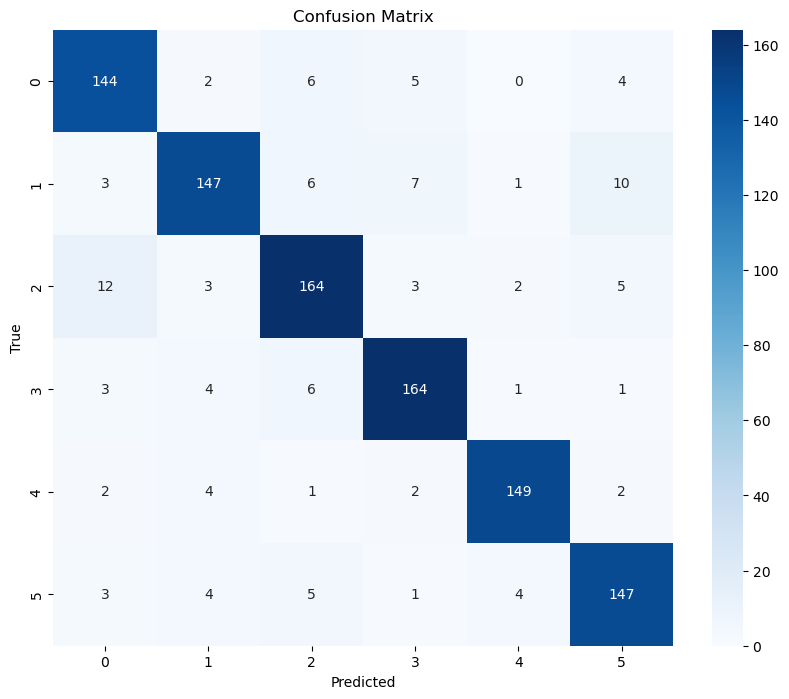

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=brand_to_label.keys(),
            yticklabels=brand_to_label.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



### Validation and Train Accuracy

In [6]:
import json 
json.dump(vgg16_selfattention.history, open('vgg16_100_epoch_bkg.json', 'w'))

In [11]:
import pandas as pd
history_100_new4 = pd.read_json('history_100_new4.json')

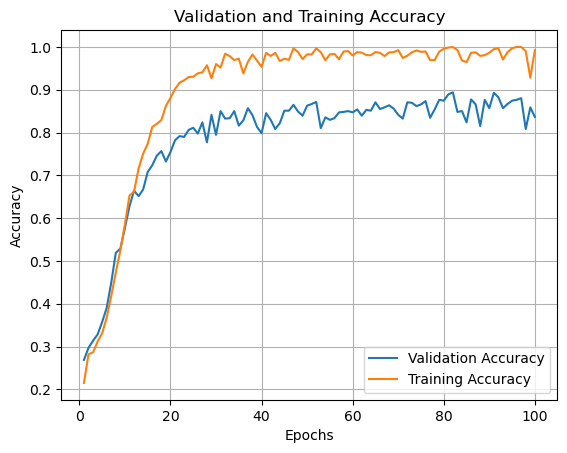

In [12]:
import matplotlib.pyplot as plt
val_accuracy = history_100_new4['val_accuracy']
accuracy = history_100_new4['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Validation and Train Loss

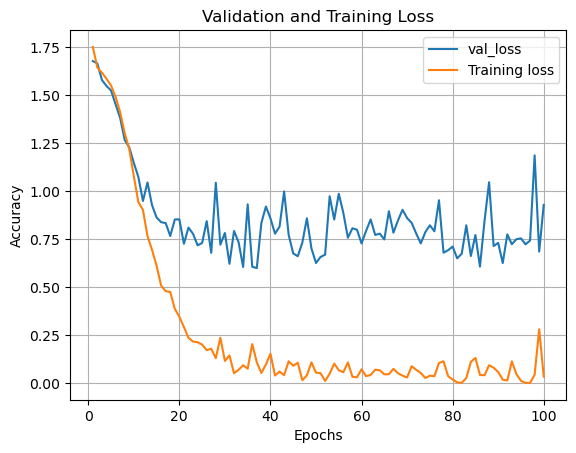

In [13]:
val_accuracy = history_100_new4['val_loss']
accuracy = history_100_new4['loss']
epochs = range(1, len(val_accuracy) + 1)

# Plotta i risultati
plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


### Accuracy (Accuratezza): 

In [38]:

# Accuratezza durante la validazione
validation_accuracy = history_100_new2.history['val_accuracy']

# Calcola la media dell'accuratezza sulla validazione
average_validation_accuracy = sum(validation_accuracy) / len(validation_accuracy)

print("Media dell'accuratezza di validazione dopo 100 epoche:", average_validation_accuracy)

Media dell'accuratezza di validazione dopo 100 epoche: 0.7864070084691047


In [39]:
# Accuratezza durante l'addestramento
training_accuracy = history_100_new2.history['accuracy']


# Calcola la media dell'accuratezza sulla validazione
average_training_accuracy = sum(training_accuracy) / len(training_accuracy)

print("Media dell'accuratezza di training dopo 100 epoche:", average_training_accuracy)


Media dell'accuratezza di training dopo 100 epoche: 0.8956475156545639


### Area Under the Receiver Operating Characteristic Curve (AUC-ROC):

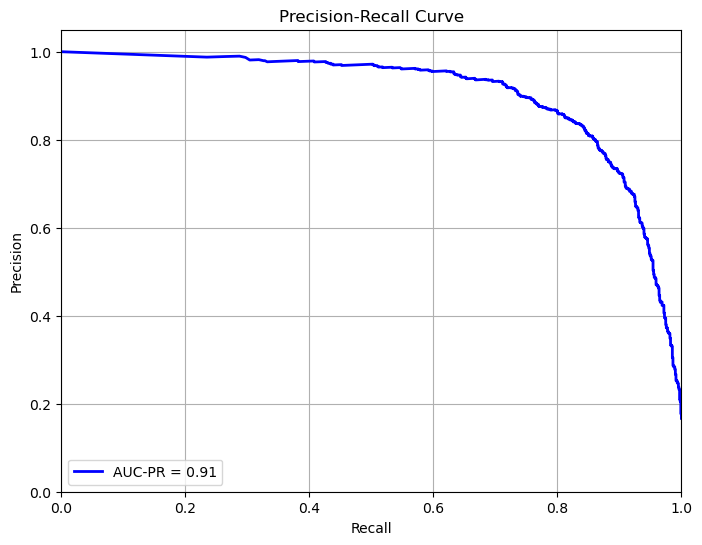

In [40]:
from sklearn.metrics import auc, precision_recall_curve
import matplotlib.pyplot as plt

# Calcola la curva precision-recall
precision, recall, _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())

# Calcola l'AUC-PR
auc_pr = auc(recall, precision)

# Visualizza la curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='AUC-PR = %0.2f' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


### Log Loss (Cross-Entropy Loss): 

In [41]:
from tensorflow.keras.losses import categorical_crossentropy

# Calcola la Log Loss sui dati di validazione
loss = categorical_crossentropy(y_val, y_pred)

# Calcola la media della Log Loss su tutti i campioni
average_loss = np.mean(loss)

print("Log Loss:", average_loss)


Log Loss: 0.8879764


### F1-Score

In [42]:
from sklearn.metrics import f1_score

# Calcola la F1-Score per le previsioni e le etichette reali
f1score = f1_score(np.argmax(y_val, axis=1), y_pred_classes, average='weighted')

print("Weighted F1-Score:", f1score)


Weighted F1-Score: 0.837351275842709


In [43]:
# Ottenere la lista dei nomi dei livelli del modello
layer_names = [layer.name for layer in model.layers]

# Stampa dei nomi dei livelli
for name in layer_names:
    print(name)

input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
attention
max_pooling2d_3
conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
dense
flatten
dense_1
dropout
dense_2


# Viz Attention

1/1 [==============================] - 0s 143ms/step


2023-08-23 15:20:58.141420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


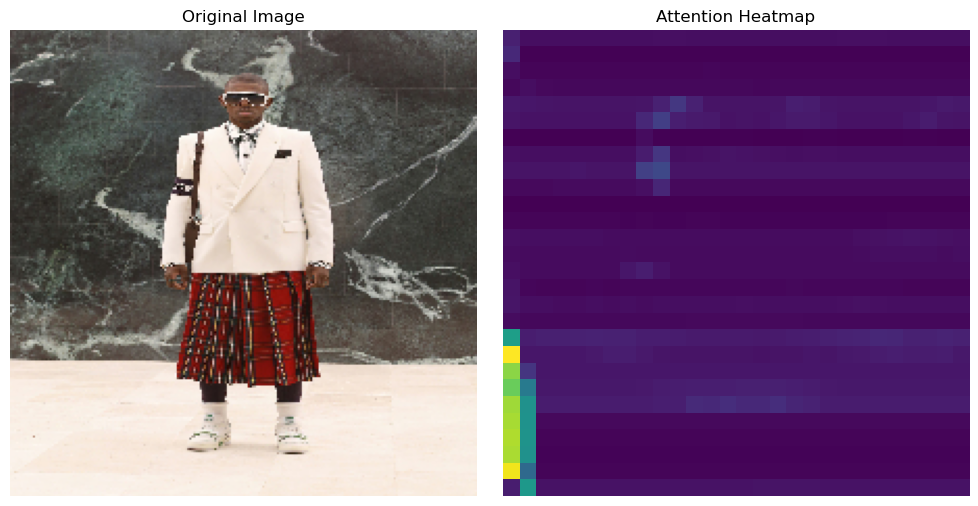

In [74]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.layers import Attention

# ... Rest of your code ...

# Convert X_val_paths to a numpy array
X_val_paths = np.array(X_val_paths)

# Choose an image index from your validation set
sample_image_index = 120 # Change this to your desired image index

# Get the image path using the chosen index
sample_image_path = X_val_paths[sample_image_index]

# Define a function to extract attention weights and generate heatmaps
def visualize_attention(model, img_path, layer_name):
    img = preprocess_image(img_path)
    img = np.expand_dims(img, axis=0)
    
    # Create a submodel that outputs attention weights
    submodel = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    attention_maps = submodel.predict(img)
    
    # Reshape attention maps for visualization
    attention_maps = np.squeeze(attention_maps)
    
    # Create a heatmap by summing along the channel axis
    heatmap = np.sum(attention_maps, axis=-1)
    
    # Normalize the heatmap
    heatmap /= np.max(heatmap)
    
    return heatmap

# Choose an image path from your validation set
#sample_image_path = X_val_paths[0]  # Change this to your desired image path

# Choose the layer name where the attention is applied (in your case, it's 'attention')
attention_layer_name = 'attention'


# Generate the attention heatmap for the chosen image and layer
heatmap = visualize_attention(model, sample_image_path, attention_layer_name)

# Display the original image and attention heatmap side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
original_image = load_img('./imgs/images/images/' + sample_image_path, target_size=(img_height, img_width))
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Attention Heatmap
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='viridis')
plt.title('Attention Heatmap')
plt.axis('off')

plt.tight_layout()
plt.show()
